<h1 align='center'>Итоговая работа</h1>


### Реализация логистической регрессии с градиентным спуском и регуляризацией
<hr>

**Цель:** 
отработать технику разработки модулей(PyCharm) для их использования в jupyter notebook

**Проведенные работы**
- подготовлен класс RegLogReg с интерфесом fit, predict, probe
  - разработка класса проведена с использованием ABC
  - класс снабжен дополнительным методом для визуализации (экспорт в png)
  - основные параметры могут быть настроены, для удобства использования проставлены дефолтные значения
- дополнительные работы:
  - написан базовый тест [test_RegLogReg.py](test_RegLogReg.py) unittest
  - итерационный процесс логирован в папку logs, пример - [rlr.py_20240303-163353_.log](logs%2Frlr.py_20240303-163353_.log)
  - предусмотрено сохранение иллюстраций ```plotly``` в папку assets, пример:

  <img src="assets/rlr.py_20240303-163353.png" width="300">
  
  - написаны вспомогательные утилиты и генератор случайных сбалансированных датасетов для Логистической регрессии на базе ```make_classification``` с сохранением в файл
- созданный класс применен в jupyter notebook, где проведены следующие работы:
  - датасеты несбалансированы относительно цели, произведено частичное усечение в рамках учебной задачи
  - небольшой EDA датасета с числовыми фичами
  - базовая доработка данных 
  - реализовано моделирование на основе разработанного класса
  - результат сравнен с базовым алгоритмом LogisticRegression

## 0. Инициализация

In [1]:
import pandas as pd
print(f'pandas: {pd.__version__}')

import numpy as np
print(f'numpy: {np.__version__}')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from IPython.display import HTML, display
import tqdm

# !pip install imbalanced-learn
# import imblearn
# print(f'imblearn: {imblearn.__version__}')

%matplotlib inline

pandas: 2.2.1
numpy: 1.25.2


## 1. Загрузка данных и краткий обзор
После загрузки данные приводятся к единообразной структуре.

Из-за того, что у нас датасеты сильно смещены в сторону no/0 (>80%) по целевому значению, в учебных целях усекаем данные для получения сбалансированного набора данных.

### Вспомогательные функции

In [2]:
def short_describe(df, target_name='target'):
    display(HTML(f'''
    <b>Shape:</b> {df.shape[0]} rows x {df.shape[1]} columns
    <br><b>Duplicates:</b> {df.duplicated().sum()}
    <br><b>Rows with null values:</b> {df.isna().any(axis=1).sum()}<hr>'''))
    display(df.describe(include='all').T)
    
    lst_num = df.select_dtypes(include='number').columns.tolist()
    lst_str = df.select_dtypes(include='object').columns.tolist()
    if len(lst_num):
        display(HTML(f'<hr><b>Numeric columns ({len(lst_num)}):</b>'))
        print(lst_num)
    if len(lst_str):
        display(HTML(f'<hr><b>String columns ({len(lst_str)}):</b>'))
        print(lst_str)
    
    display(HTML("<hr>\n<b>Balance</b>"))
    display(df[target_name].value_counts(normalize=True))

    return lst_num, lst_str

def make_well_balance_df(df, target_name = 'target', minor_value = 1, coeff = 0.1 ):
    '''
    функция создает датафрейм со сдвигом в "большем классе" количества значений на указанный %
    '''
    df_ones = df[df[target_name] == minor_value]
    ones_count=np.round(df_ones.shape[0] * (1 + coeff)).astype(int)
    df_zeros = df[df[target_name] != minor_value].sample(n=ones_count)
    return pd.concat([df_ones, df_zeros]).drop_duplicates()

bank-additional-full.zip - The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. , <a href="https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing/data">kaggle bank-marketing</a>

In [3]:
%%time

strFileName1='data/bank-additional-full.zip'
df1 = pd.read_csv(strFileName1, compression='zip', sep=';')
df1.head()
df1['y'] = df1['y'].map({'yes': 1, 'no': 0})
df1.rename(columns={'y': 'target'}, inplace=True)

# Создаем новый набор данных
df1 = make_well_balance_df(df1, coeff = .3)
df1.name='Bank marketing'
        
cols_num1, cols_str1 = short_describe(df1, target_name='target')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,10670.0,NaN,NaN,NaN,40.334677,11.779967,17.0,31.0,38.0,48.0,98.0
job,10670,12,admin.,2825,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,10670,4,married,6239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,10670,8,university.degree,3381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,10670,2,no,8822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,10670,3,yes,5595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,10670,3,no,8792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,10670,2,cellular,7588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,10670,10,may,3010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,10670,5,thu,2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN


['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'target']


['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


target
0    0.56523
1    0.43477
Name: proportion, dtype: float64

CPU times: user 81 ms, sys: 29 ms, total: 110 ms
Wall time: 110 ms


---

Теперь наборы данных хорошо сбалансированы относительно цели.

---
## 2. Доработаем фичи в набое данных.

#### Bank marketing
Изучим категориальные поля. Из описания датасета известно, что вариантивность каждого из этих полей относительно небольшая, часть полей имеет одинаковое значение 'unknown'. 

In [4]:
# Изучим текстовые поля
display(HTML(f'<b>{df1.name}</b><hr>'))
total = df1.shape[0]
df=df1

for f in cols_str1:
    u = df[f].unique()
    u_text = ''
    if 'unknown' in u:
        c = df[df[f]=='unknown'].shape[0]
        cc = np.round(c*100/total,1)
        u_text = f', <i>unknown =</i> {c} ({cc}%)'
    cross = df.pivot_table(index=f, columns='target', aggfunc='size', fill_value=0)
    display(HTML(f"<b>{f}</b><br>unique = {len(u)}{u_text}:"))
    display(cross.T)

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
target,,,,,,,,,,,,
0,1474,1436,229,152,434,200,204,593,97,1012,148,52
1,1351,638,124,106,328,434,149,323,275,730,144,37


marital,divorced,married,single,unknown
target,,,,
0,635,3708,1674,14
1,476,2531,1620,12


education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
target,,,,,,,,
0,614,348,908,1406,2,800,1712,241
1,428,188,473,1031,4,595,1669,251


default,no,unknown
target,,
0,4626,1405
1,4196,443


housing,no,unknown,yes
target,,,
0,2813,130,3088
1,2025,107,2507


loan,no,unknown,yes
target,,,
0,4943,130,958
1,3849,107,683


contact,cellular,telephone
target,,
0,3736,2295
1,3852,787


month,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
target,,,,,,,,,,
0,370,914,12,1056,780,50,2124,610,67,48
1,539,655,89,648,559,276,886,416,315,256


day_of_week,fri,mon,thu,tue,wed
target,,,,,
0,1187,1257,1232,1208,1147
1,846,847,1044,953,949


poutcome,failure,nonexistent,success
target,,,
0,644,5301,86
1,605,3140,894


Исходя из узких учебных задач часть данных можно удалить.

In [5]:
print(f'Before drop df1.shape:{df1.shape}')
condition = (df1['default'] == 'yes') |(df1['marital'] == 'unknown') |(df1['education']=='illiterate') |(df1['job']=='unknown')
s = df1[condition].shape[0]
print(f'Count bad rows = {s} ({np.round(s*100/df1.shape[0],2)}%)')
df1 = df1.drop(df1[condition].index)
print(f'After drop df1.shape:{df1.shape}')

Before drop df1.shape:(10670, 21)
Count bad rows = 117 (1.1%)
After drop df1.shape:(10553, 21)


<br><br>Остальные переменные кодируем LabelEncoder

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
labelencoder_X = LabelEncoder()
for f in cols_str1:
    df1[f]= labelencoder_X.fit_transform(df1[f])
df1[cols_str1].head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
75,1,0,0,1,2,0,1,6,1,1
83,2,1,5,1,2,0,1,6,1,1
88,9,1,2,0,0,0,1,6,1,1
129,9,1,4,1,2,0,1,6,1,1
139,1,1,2,1,2,0,1,6,1,1


<br><br> Рассмотрим фичи с численными значениями.
<br> Пока откладываем: <br>Duration: last contact duration, in seconds (numeric) и <br>Euribor3m: euribor 3 month rate - daily indicator (numeric)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


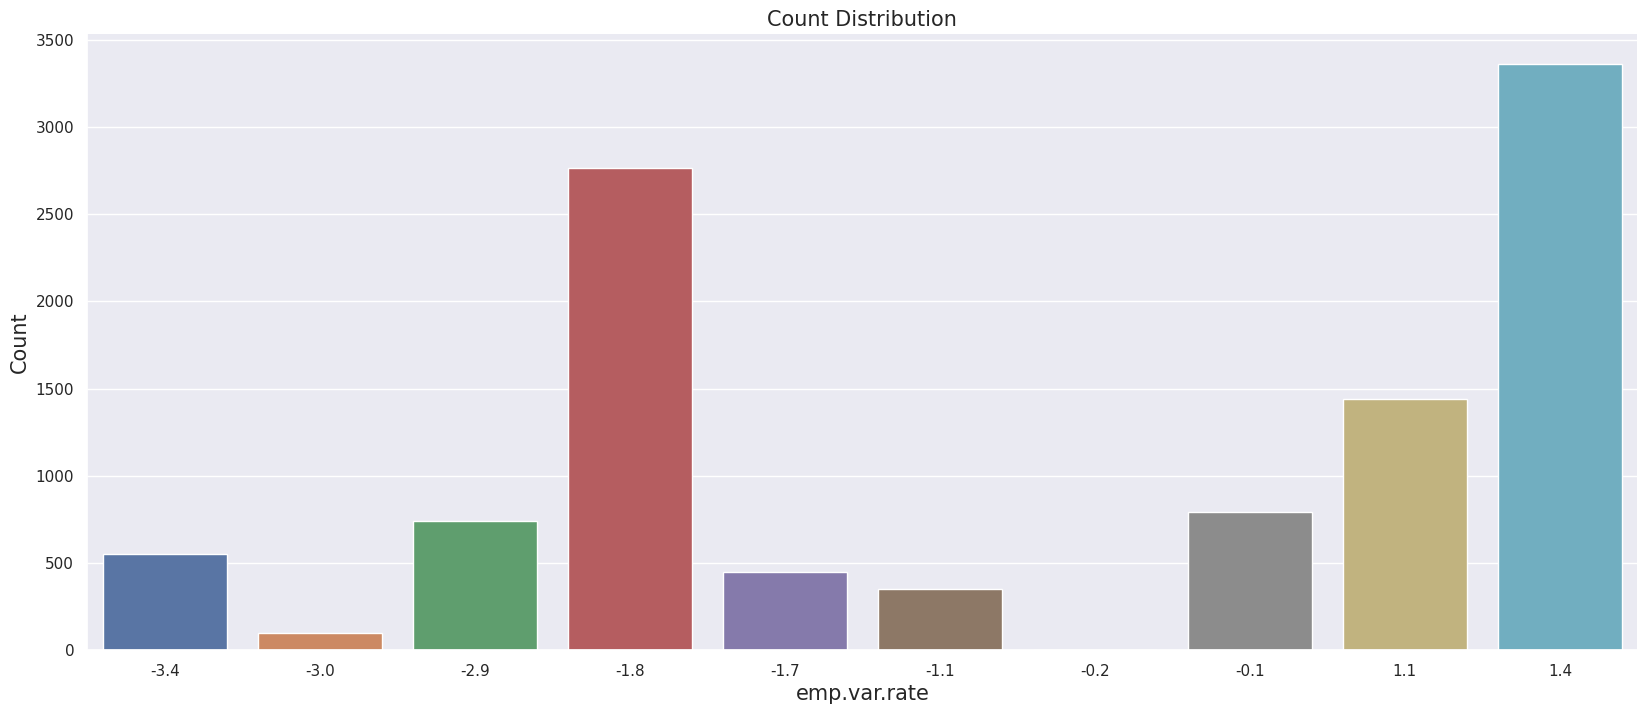

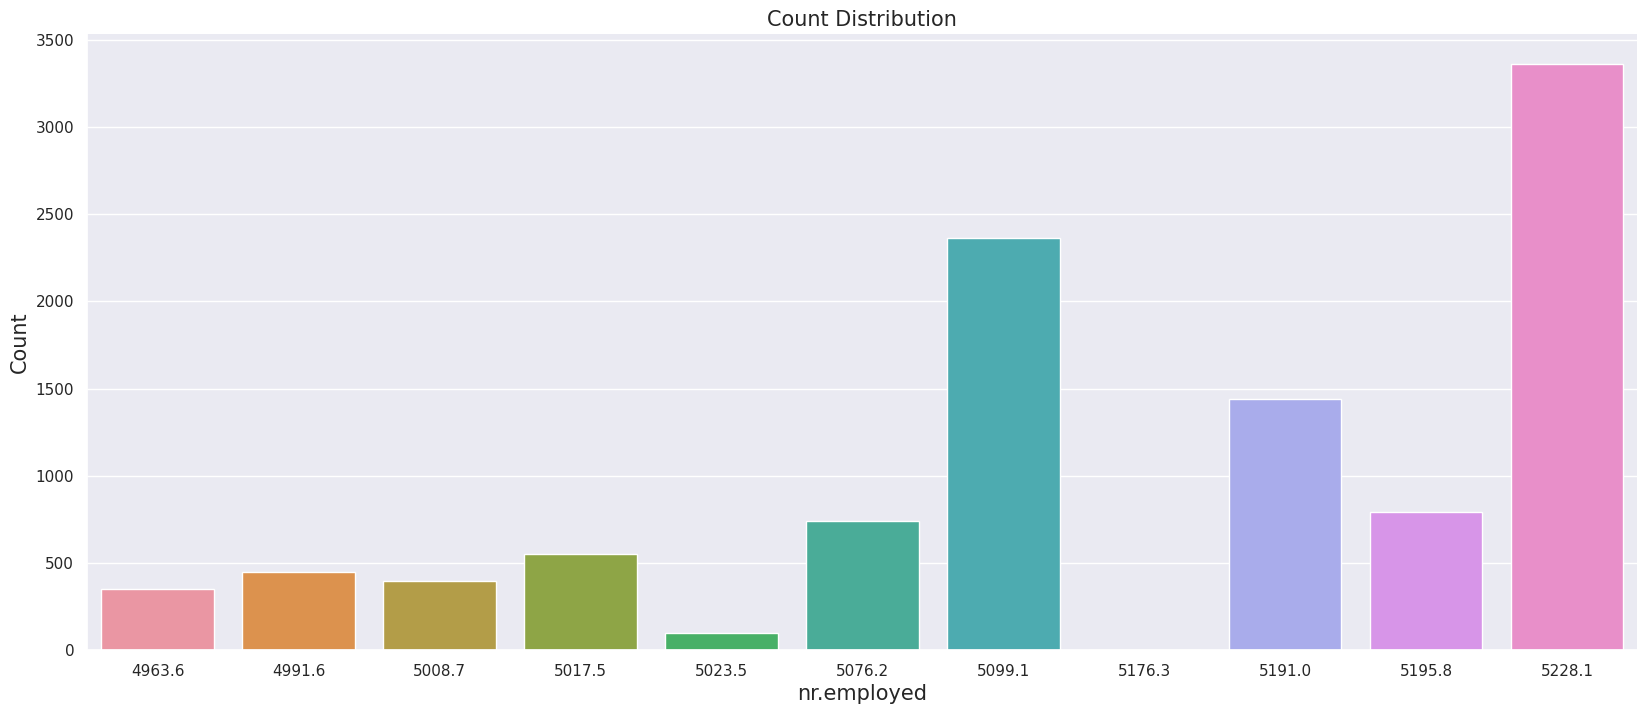

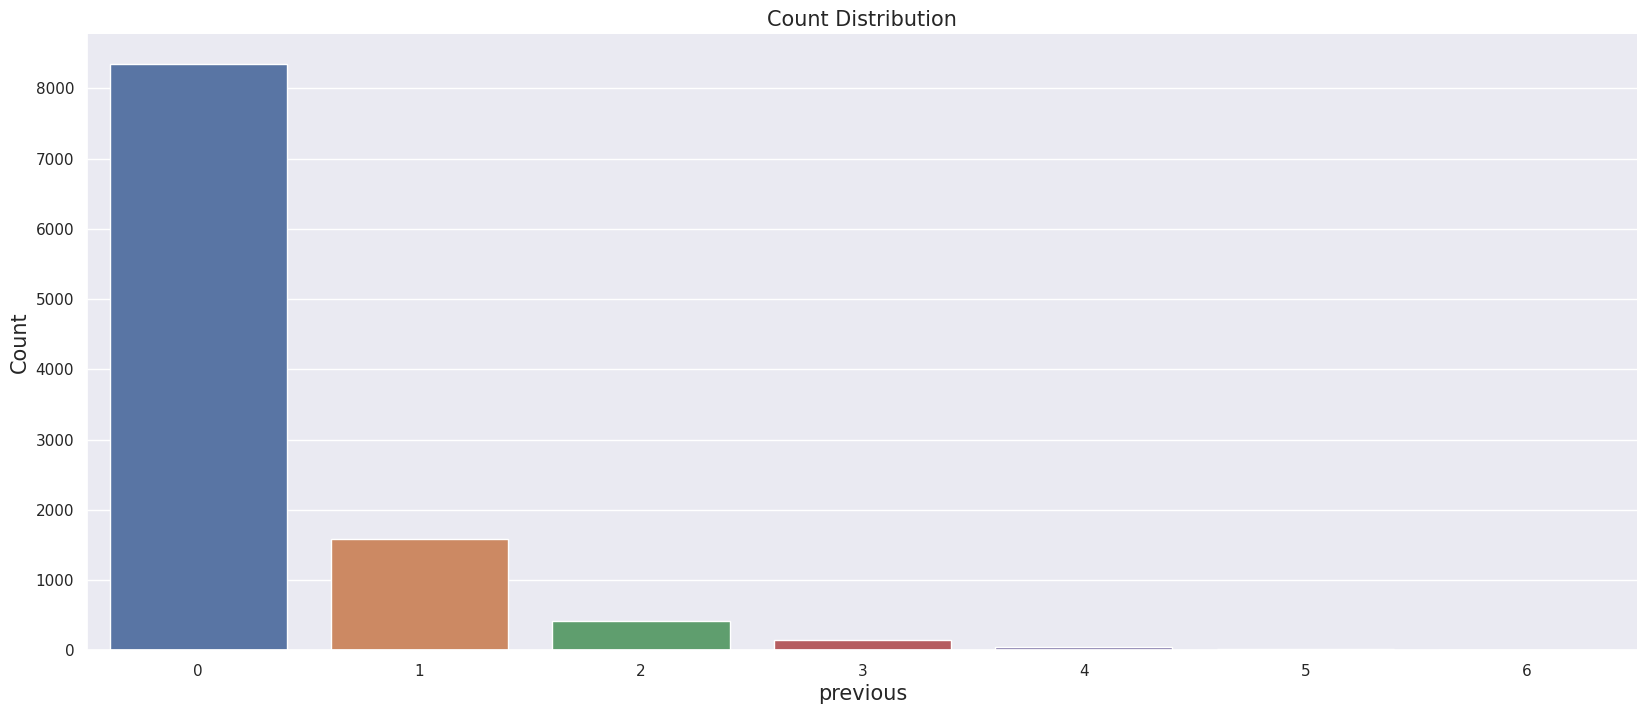

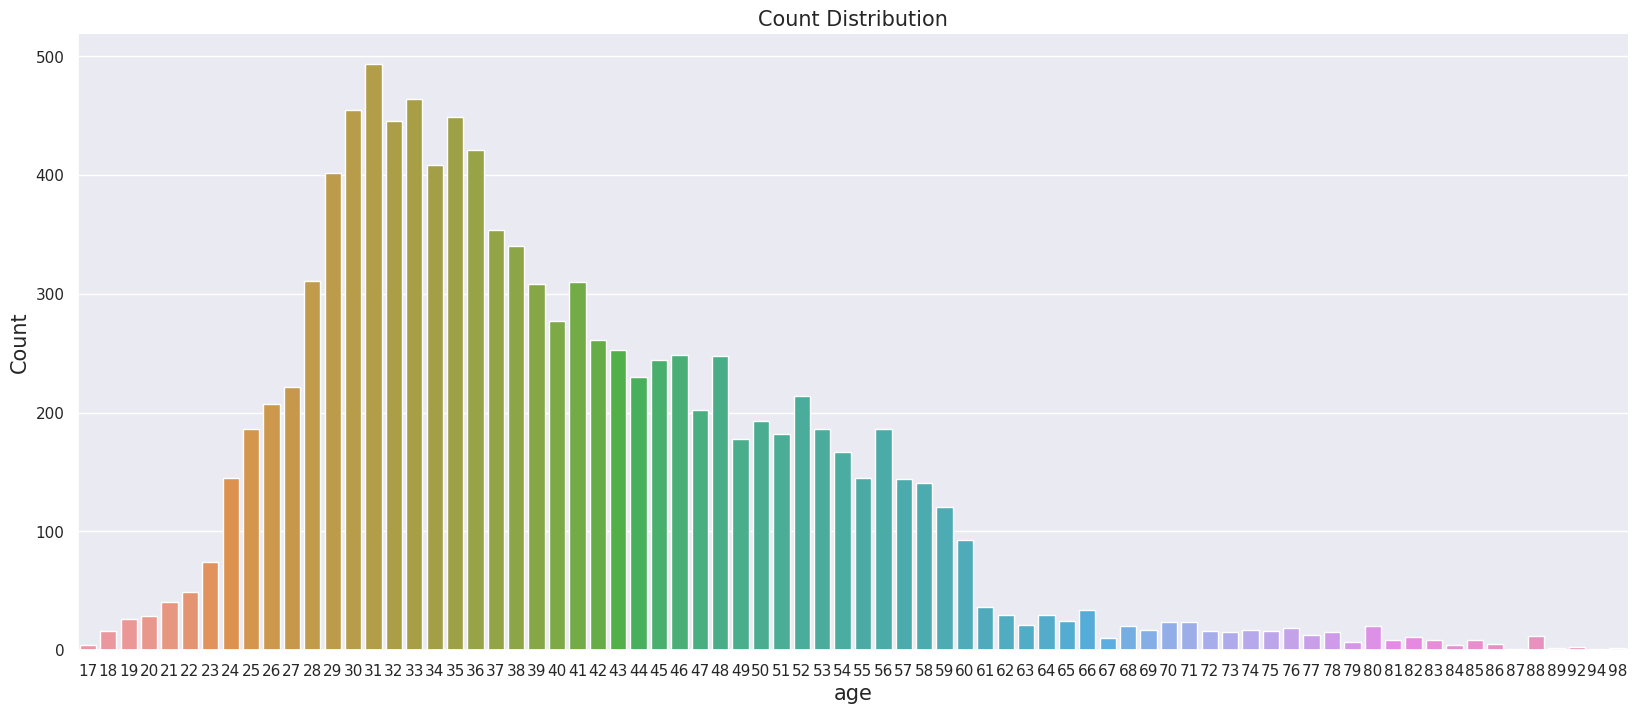

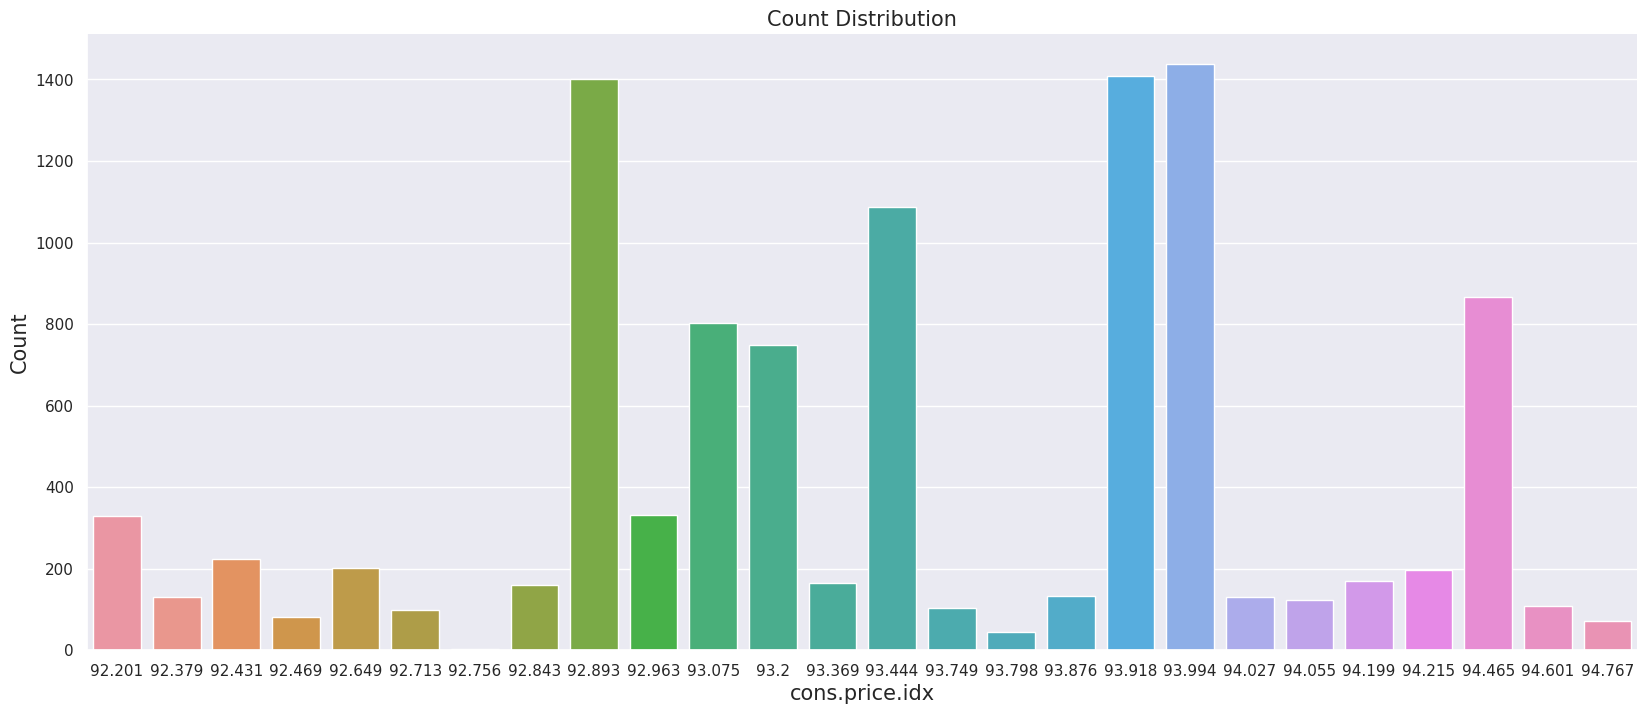

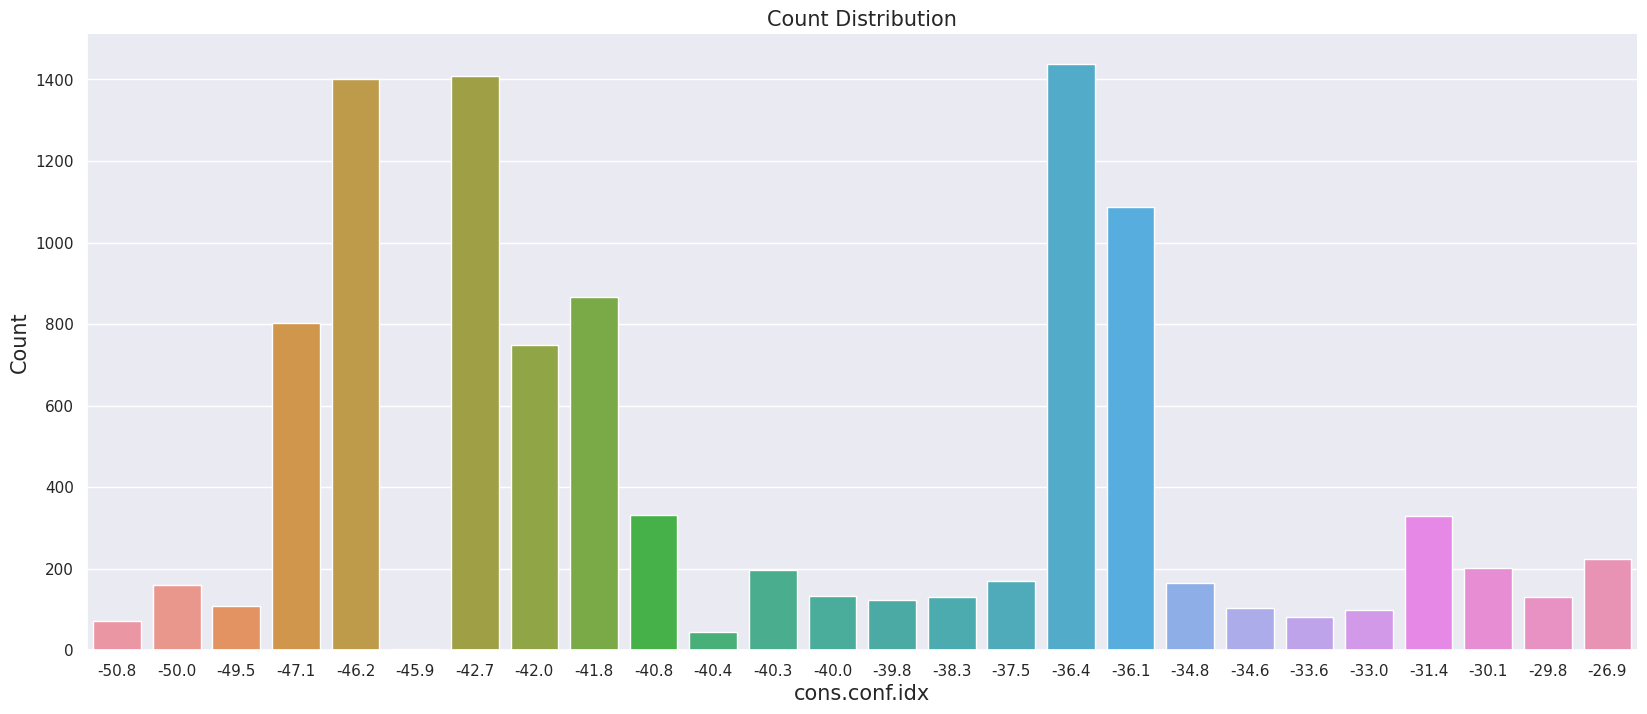

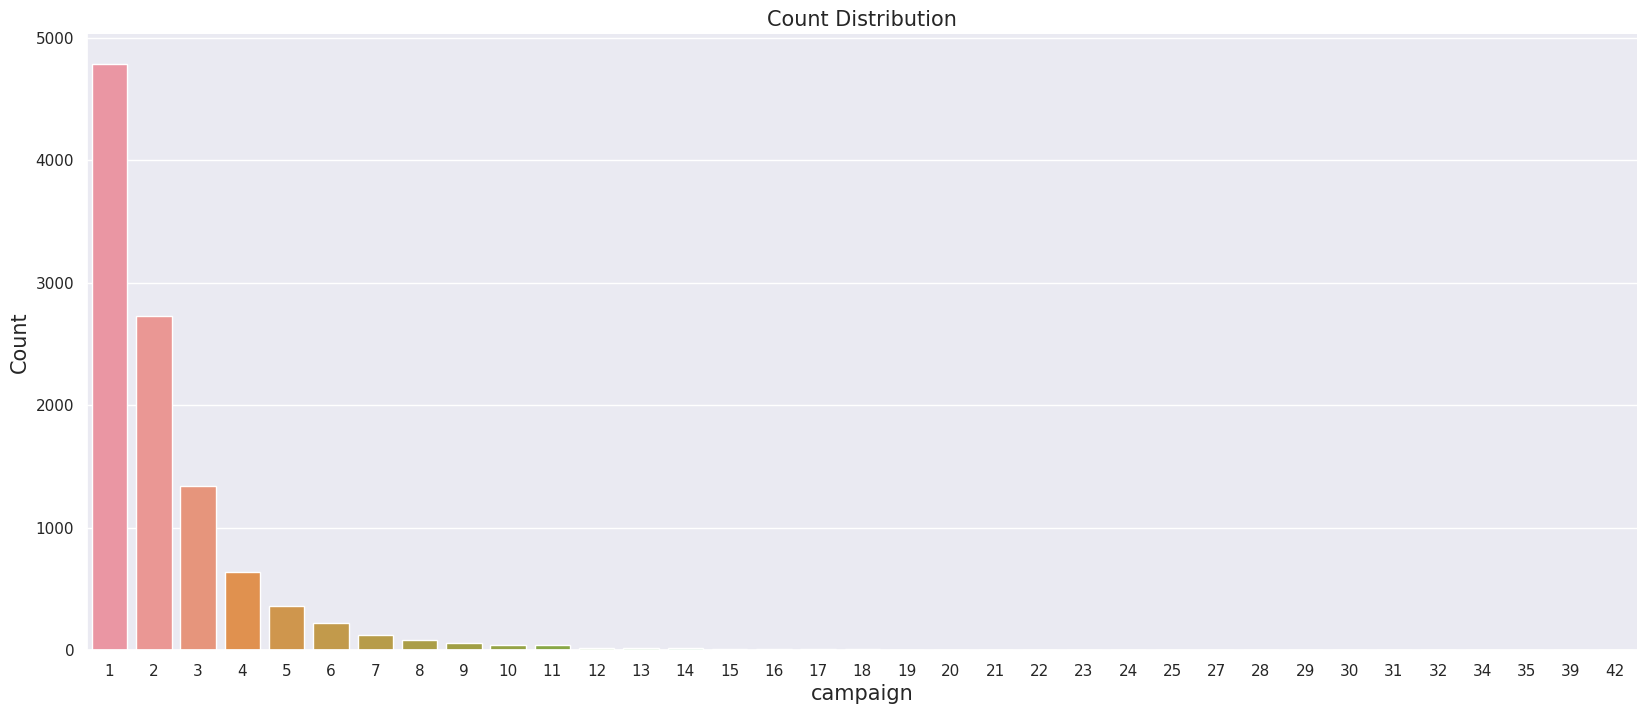

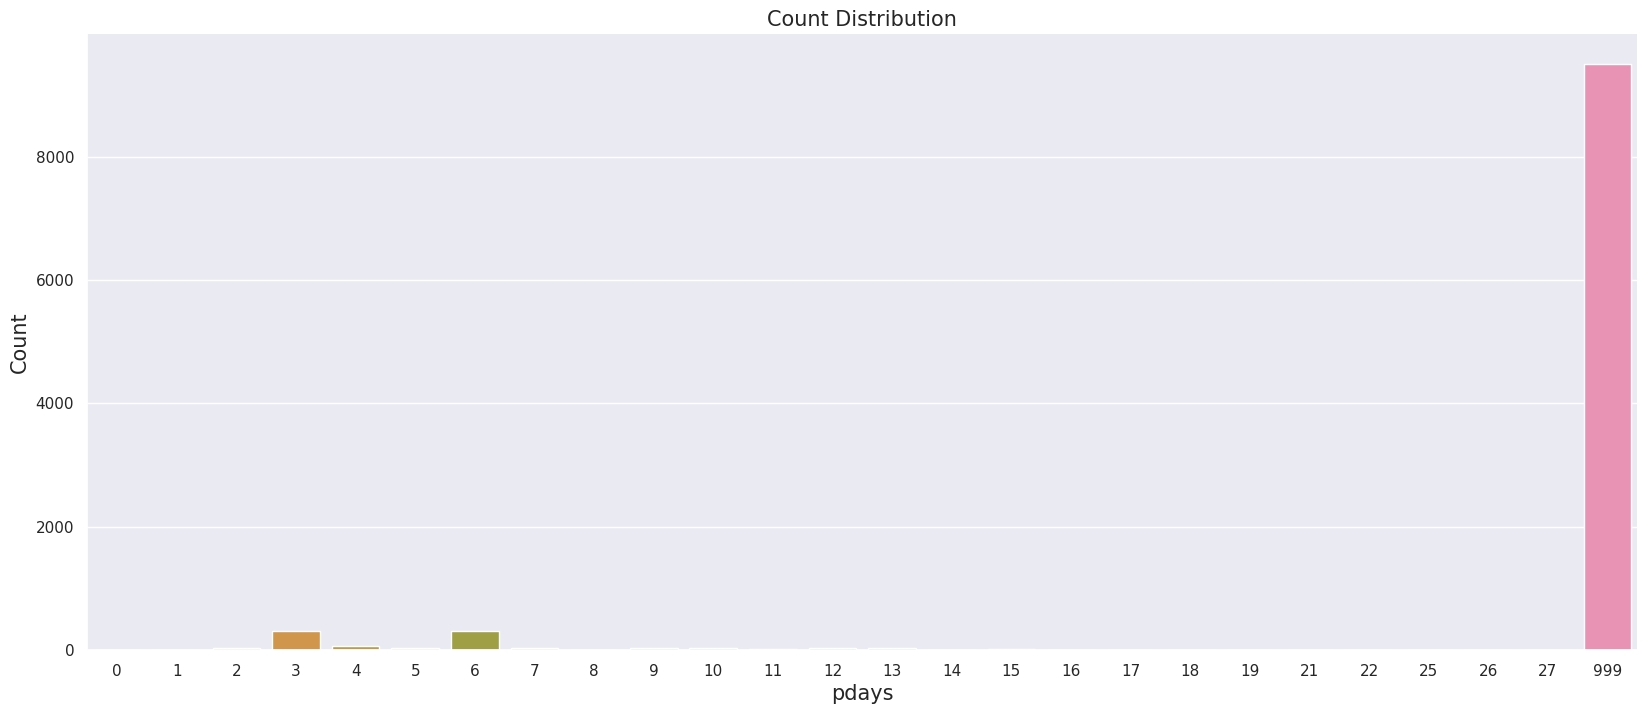

In [8]:
%time
for f in list(set(cols_num1) - {'target','duration','euribor3m'}):
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 8)
    sns.countplot(x = f, data = df1)
    ax.set_xlabel(f, fontsize=15)
    ax.set_ylabel('Count', fontsize=15)
    ax.set_title(f'Count Distribution', fontsize=15)
    sns.despine()

По фичам <br>'previous', 'age', 'campaign' приравнять выбросы прилегающим меньшим/большим значениям
<br> 'pdays' - скорее всего можно удалить из набора целиком
<br> 'nr.employed', 'emp.var.rate' - рассмотреть удаления строк с редкими значениями

In [9]:
df1.loc[df1['previous'] > 3, 'previous'] = 3
df1.loc[df1['campaign'] > 9, 'campaign'] = 9

df1.loc[df1['age'] < 24, 'age'] = 24
df1.loc[df1['age'] > 60, 'age'] = 60

z_features = ['previous', 'campaign', 'age']
for f in z_features:
    display(df1[f].value_counts(normalize=True).to_frame().T)


previous,0,1,2,3
proportion,0.791434,0.149531,0.039704,0.019331


campaign,1,2,3,4,5,9,6,7,8
proportion,0.45371,0.258505,0.126883,0.060172,0.034493,0.026059,0.020752,0.011655,0.00777


age,60,31,33,30,35,32,36,34,29,24,...,25,56,53,51,49,54,55,57,58,59
proportion,0.054013,0.046811,0.043969,0.043116,0.042547,0.042263,0.039894,0.038757,0.038093,0.036388,...,0.017625,0.017625,0.017625,0.017246,0.016867,0.015825,0.01374,0.013645,0.013361,0.011466


In [10]:
df1 = df1.drop('pdays', axis=1)

In [11]:
rare_values_nr_employed = [5176.3, 5023.5]
rare_values_emp_var_rate = [-0.2, -3.0]

condition = (df1['nr.employed'].isin(rare_values_nr_employed)) | (df1['emp.var.rate'].isin(rare_values_emp_var_rate))

rare_cases_count = df1[condition].shape[0]
rare_cases_percentage = rare_cases_count / df.shape[0]

df1 = df1.drop(df1[condition].index)
print(f'Rare cases count: {rare_cases_count}, Percentage: {rare_cases_percentage}')
print(f'After drop, df shape: {df.shape}')

Rare cases count: 100, Percentage: 0.00937207122774133
After drop, df shape: (10670, 21)


<br><br> Переведем 'duration' в категориальные переменные

In [12]:
df1.loc[df1['duration'] <= 102, 'duration'] = 1
df1.loc[(df1['duration'] > 102) & (df1['duration'] <= 180)  , 'duration'] = 2
df1.loc[(df1['duration'] > 180) & (df1['duration'] <= 319)  , 'duration'] = 3
df1.loc[(df1['duration'] > 319) & (df1['duration'] <= 644.5), 'duration'] = 4
df1.loc[df1['duration']  > 644.5, 'duration'] = 5

<br><br>
Проведем стандартизацию оставшихся числовых фичей.

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
numerical_features = list(set(cols_num1) - {'target','pdays','duration'})
scaler = StandardScaler()
df1[numerical_features] = scaler.fit_transform(df1[numerical_features])

<br><br>
#### Подводим итог

In [15]:
cols_num1, cols_str1 = short_describe(df1, target_name='target')

,count,mean,std,min,25%,50%,75%,max
age,10453.0,2.229580e-16,1.000048,-1.534716,-0.853816,-0.172917,0.799797,1.967054
job,10453.0,3.761217e+00,3.576510,0.000000,0.000000,3.000000,7.000000,10.000000
marital,10453.0,1.205683e+00,0.610674,0.000000,1.000000,1.000000,2.000000,2.000000
education,10453.0,3.372620e+00,1.690387,0.000000,2.000000,3.000000,5.000000,6.000000
default,10453.0,1.732517e-01,0.378483,0.000000,0.000000,0.000000,0.000000,1.000000
housing,10453.0,1.070506e+00,0.986371,0.000000,0.000000,2.000000,2.000000,2.000000
loan,10453.0,3.289008e-01,0.726279,0.000000,0.000000,0.000000,0.000000,2.000000
contact,10453.0,2.893906e-01,0.453501,0.000000,0.000000,0.000000,1.000000,1.000000
month,10453.0,4.228738e+00,2.483318,0.000000,3.000000,4.000000,6.000000,9.000000
day_of_week,10453.0,2.013967e+00,1.397060,0.000000,1.000000,2.000000,3.000000,4.000000


['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'target']


target
0    0.569406
1    0.430594
Name: proportion, dtype: float64

## 3. Логистическая регрессия

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import linear_model, datasets

from rlr import RegLogReg
%load_ext autoreload
%autoreload 2

In [17]:
X = df1[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]
y = df1['target']

# Разделяем данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=202402)

# Инициализируем и обучаем модель логистической регрессии
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

model1 = RegLogReg()
model1.fit(X_train, y_train)

# Делаем предсказания
y_pred = model.predict(X_test)
y_pred1 = model1.predict(X_test)

# Оцениваем качество модели
print("Accuracy LogisticRegression:\n", accuracy_score(y_test, y_pred))
print("Accuracy RegLogReg:\n", accuracy_score(y_test, y_pred1),'\n')
print(f'confusion matrix LogisticRegression: \n{confusion_matrix(y_test, y_pred)}')
print(f'confusion matrix RegLogReg: \n{confusion_matrix(y_test, y_pred1)}\n')
print(f'classification report LogisticRegression: \n{classification_report(y_test, y_pred)}')
print(f'classification report RegLogReg: \n{classification_report(y_test, y_pred1)}')

Accuracy LogisticRegression:
 0.8520408163265306
Accuracy RegLogReg:
 0.8504464285714286 

confusion matrix LogisticRegression: 
[[1533  246]
 [ 218 1139]]
confusion matrix RegLogReg: 
[[1533  246]
 [ 223 1134]]

classification report LogisticRegression: 
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1779
           1       0.82      0.84      0.83      1357

    accuracy                           0.85      3136
   macro avg       0.85      0.85      0.85      3136
weighted avg       0.85      0.85      0.85      3136

classification report RegLogReg: 
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1779
           1       0.82      0.84      0.83      1357

    accuracy                           0.85      3136
   macro avg       0.85      0.85      0.85      3136
weighted avg       0.85      0.85      0.85      3136



<hr><hr><hr>

## Резервный набор данных для тестирования

#### Heart disease
framingham.csv - Logistic regression To predict heart disease, <a href="https://www.kaggle.com/datasets/dileep070/heart-disease-prediction-using-logistic-regression/data">kaggle heart-disease-prediction-using-logistic-regression</a>

In [18]:
%%time

strFileName2='data/framingham.csv'
df2 = pd.read_csv(strFileName2)
df2.rename(columns={'TenYearCHD': 'target'}, inplace=True)

# Создаем новый набор данных
df2 = make_well_balance_df(df2)
df2.name='Heart disease'

cols_num2, cols_str2 = short_describe(df2, target_name='target')  

,count,mean,std,min,25%,50%,75%,max
male,1352.0,0.458580,0.498466,0.00,0.00,0.00,1.000,1.0
age,1352.0,51.175296,8.701032,32.00,44.00,51.00,58.000,70.0
education,1321.0,1.957608,1.039969,1.00,1.00,2.00,3.000,4.0
currentSmoker,1352.0,0.514053,0.499987,0.00,0.00,1.00,1.000,1.0
cigsPerDay,1345.0,9.719703,12.463438,0.00,0.00,1.00,20.000,70.0
BPMeds,1332.0,0.045045,0.207481,0.00,0.00,0.00,0.000,1.0
prevalentStroke,1352.0,0.008876,0.093827,0.00,0.00,0.00,0.000,1.0
prevalentHyp,1352.0,0.377959,0.485057,0.00,0.00,0.00,1.000,1.0
diabetes,1352.0,0.036243,0.186962,0.00,0.00,0.00,0.000,1.0
totChol,1340.0,239.475373,46.164399,107.00,208.00,237.00,266.000,600.0


['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'target']


target
0    0.523669
1    0.476331
Name: proportion, dtype: float64

CPU times: user 133 ms, sys: 212 ms, total: 346 ms
Wall time: 32.5 ms
